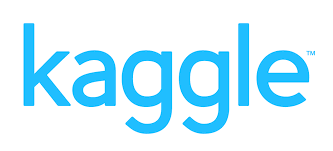

**Group 5**
* Apurva Shekhar
- Suchita Negi



## <span style='font-family:Georgia'> Data Overview

* The data was collected from data professionals  in Kaggle survey (2019) .
* This survey received 19,717 usable respondents from 171 countries and territories.
* The results include raw numbers about who is working with data, what’s happening with machine learning in different industries, and the best ways for new data scientists to break into the field.
- https://www.kaggle.com/c/kaggle-survey-2019

* <span style='font-family:Georgia'> External Data Sets
    
 * <span style='font-family:Georgia'>  Conversion rate table: We merged the conversion rate table to our dataset (https://data.oecd.org/conversion/exchange-rates.htm) 
    
 * <span style='font-family:Georgia'> Purchasing power parity: To compare economic productivity and standards of living between countries is purchasing power parity. (https://data.worldbank.org/indicator/PA.NUS.PRVT.PP) To bring the salaries of each country at the same scale with that of USA, we used this data set. The process is explained later in the analysis.

In [1]:
# Print all the outputs in a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import re
import seaborn as sns
import sklearn as sk
import sklearn.tree as tree
from scipy import stats
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression

import statsmodels as sm
import numpy as np
import pydotplus
import plotly.express as px
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.offline as pyo
import plotly.express as px
from IPython.display import Image  
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Load Data

In [3]:
# Response data frame has one entry per response. There are 235 columns in the response data frame.
response_df = pd.read_csv('multiple_choice_responses_19.csv')
# Purchase parity data
purchase_parity_df = pd.read_csv('purchase_parity.csv', skiprows=4)
# Conversion rate data
currency_rate_df = pd.read_csv('currency_rate.csv') 

In [4]:
response_df.shape

(19718, 246)

In [5]:
response_df.head()

,Time from Start to Finish (seconds),Q1,Q2,Q2_OTHER_TEXT,Q3,Q4,Q5,Q5_OTHER_TEXT,Q6,Q7,...,Q34_Part_4,Q34_Part_5,Q34_Part_6,Q34_Part_7,Q34_Part_8,Q34_Part_9,Q34_Part_10,Q34_Part_11,Q34_Part_12,Q34_OTHER_TEXT
0,Duration (in seconds),What is your age (# years)?,What is your gender? - Selected Choice,What is your gender? - Prefer to self-describe...,In which country do you currently reside?,What is the highest level of formal education ...,Select the title most similar to your current ...,Select the title most similar to your current ...,What is the size of the company where you are ...,Approximately how many individuals are respons...,...,Which of the following relational database pro...,Which of the following relational database pro...,Which of the following relational database pro...,Which of the following relational database pro...,Which of the following relational database pro...,Which of the following relational database pro...,Which of the following relational database pro...,Which of the following relational database pro...,Which of the following relational database pro...,Which of the following relational database pro...
1,510,22-24,Male,-1,France,Master’s degree,Software Engineer,-1,"1000-9,999 employees",0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
2,423,40-44,Male,-1,India,Professional degree,Software Engineer,-1,"> 10,000 employees",20+,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
3,83,55-59,Female,-1,Germany,Professional degree,NaN,-1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
4,391,40-44,Male,-1,Australia,Master’s degree,Other,0,"> 10,000 employees",20+,...,NaN,NaN,NaN,NaN,NaN,Azure SQL Database,NaN,NaN,NaN,-1


In [6]:
response_df.isna().sum()

Time from Start to Finish (seconds)        0
Q1                                         0
Q2                                         0
Q2_OTHER_TEXT                              0
Q3                                         0
                                       ...  
Q34_Part_9                             19238
Q34_Part_10                            19191
Q34_Part_11                            18472
Q34_Part_12                            19430
Q34_OTHER_TEXT                             0
Length: 246, dtype: int64

In [7]:
response_df.notna().sum()

Time from Start to Finish (seconds)    19718
Q1                                     19718
Q2                                     19718
Q2_OTHER_TEXT                          19718
Q3                                     19718
                                       ...  
Q34_Part_9                               480
Q34_Part_10                              527
Q34_Part_11                             1246
Q34_Part_12                              288
Q34_OTHER_TEXT                         19718
Length: 246, dtype: int64

<span style='font-family:Georgia'> There are 246 columns and 19718 rows in the dataset. Each row is a respondent and the columns are the answers to the questions of the survey. 

# Cleanup Data

<span style='font-family:Georgia'> We wrote a function to get all the choices that were available for each question. After we extracted the choices, 
we created a dictionary to rename all the columns required for our analysis.

In [8]:
# Generate a string that can be used as python dictionary to rename columns
for index, value in response_df.T[1:].iterrows():
    v = value[0]
    v = v.strip()
    if v.endswith(' - Text'):
        v = v[:v.rfind(' - Text')]
    multi_choice_idx = v.find('- Selected Choice -')
    if multi_choice_idx != -1:
        v = v[multi_choice_idx + 20:]
    multi_choice_idx = v.rfind('(Include text response) - ')
    if multi_choice_idx != -1:
        v = v[multi_choice_idx + 26:]
    if v.endswith(')'):
        v = v[:v.rfind('(')]
    v = v.lower()
    v = v.strip()
    # Uncomment to generate column_rename_dict. This line will give the question number and column names
    # print(f"'{index}': '{v}'")

# Column rename map created by copy pasting generated string from
# the code block above, and editing by hand for better column names.
column_rename_dict = {
'Q1': 'age',
'Q2': 'gender',
'Q2_OTHER_TEXT': 'gender_other_text',
'Q3': 'country',
'Q4': 'education',
'Q5': 'title',
'Q5_OTHER_TEXT': 'title_other_text',
'Q6': 'company_size',
'Q7': 'data_team_size',
'Q8': 'employer_uses_ml',
'Q10': 'salary',
'Q11': 'ml_spending',
'Q13_Part_1': 'udacity',
'Q13_Part_2': 'coursera',
'Q13_Part_3': 'edx',
'Q13_Part_4': 'datacamp',
'Q13_Part_5': 'dataquest',
'Q13_Part_6': 'kaggle_courses',
'Q13_Part_7': 'fast.ai',
'Q13_Part_8': 'udemy',
'Q13_Part_9': 'linkedin_learning',
'Q13_Part_10': 'university_courses',
'Q13_Part_11': 'platform_none',
'Q13_Part_12': 'platform_other',
'Q13_OTHER_TEXT': 'platform_other_text',
'Q15': 'coding_exp',
'Q16_Part_1': 'jupyter',
'Q16_Part_2': 'rstudio',
'Q16_Part_3': 'pycharm',
'Q16_Part_4': 'atom',
'Q16_Part_5': 'matlab',
'Q16_Part_6': 'visual_studio',
'Q16_Part_7': 'spyder',
'Q16_Part_8': 'vim/emacs',
'Q16_Part_9': 'notepad++',
'Q16_Part_10': 'sublime',
'Q16_Part_11': 'ide_none',
'Q16_Part_12': 'ide_other',
'Q16_OTHER_TEXT': 'ide_other_text',
'Q18_Part_1': 'python',
'Q18_Part_2': 'r',
'Q18_Part_3': 'sql',
'Q18_Part_4': 'c',
'Q18_Part_5': 'c++',
'Q18_Part_6': 'java',
'Q18_Part_7': 'javascript',
'Q18_Part_8': 'typescript',
'Q18_Part_9': 'bash',
'Q18_Part_10': 'matlab',
'Q18_Part_11': 'programming_language_none',
'Q18_Part_12': 'programming_language_other',
'Q18_OTHER_TEXT': 'programming_language_other_text',
'Q19': 'recommended_language',
'Q19_OTHER_TEXT': 'recommended_language_other_text',
'Q23': 'ml_exp',
}

# Renaming the columns
response_df = response_df.rename(columns=column_rename_dict)

# Running this mutiple times may result in '0' not found error. 
response_df = response_df.drop(0)

### <span style='font-family:Georgia'> Dictionary to rename the countries which were not in the readable format

In [9]:
# Dictionary to rename the columns of country
country_rename_dict = {
    'United States of America': 'USA',
    'United Kingdom of Great Britain and Northern Ireland': 'UK',
    'Iran, Islamic Republic of...': 'Iran',
    'Hong Kong (S.A.R.)': 'Hong Kong',
    "People 's Republic of China": "China",
    'Republic of Korea': 'South Korea',
    'Iran, Islamic Rep.': 'Iran',
    'Egypt, Arab Rep.': 'Egypt',
    'Hong Kong SAR, China': 'Hong Kong',
    'Russian Federation': 'Russia',
    'Korea, Rep.': 'South Korea',
    'United Kingdom': 'UK',
    'United States': 'USA',
    'Vietnam': 'Viet Nam'
}
# Renaming the country into proper format
response_df.replace(country_rename_dict, inplace=True)

In [10]:
response_df.head()

,Time from Start to Finish (seconds),age,gender,gender_other_text,country,education,title,title_other_text,company_size,data_team_size,...,Q34_Part_4,Q34_Part_5,Q34_Part_6,Q34_Part_7,Q34_Part_8,Q34_Part_9,Q34_Part_10,Q34_Part_11,Q34_Part_12,Q34_OTHER_TEXT
1,510,22-24,Male,-1,France,Master’s degree,Software Engineer,-1,"1000-9,999 employees",0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
2,423,40-44,Male,-1,India,Professional degree,Software Engineer,-1,"> 10,000 employees",20+,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
3,83,55-59,Female,-1,Germany,Professional degree,NaN,-1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
4,391,40-44,Male,-1,Australia,Master’s degree,Other,0,"> 10,000 employees",20+,...,NaN,NaN,NaN,NaN,NaN,Azure SQL Database,NaN,NaN,NaN,-1
5,392,22-24,Male,-1,India,Bachelor’s degree,Other,1,0-49 employees,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1


###  <span style='font-family:Georgia'> Changed the categorical columns into numerical columns

<span style='font-family:Georgia'> In this dataset, there are not many numerical columns. Columns like **age**, **salary**, **coding experience** 
are also categorical. These categorical data was not very helpful for our analysis. 

<span style='font-family:Georgia'> We decided to change the categorical column to numerical column. The logic is explained below.

#### <span style='font-family:Georgia'> Steps- 

<span style='font-family:Georgia'> 1. Wrote functions to convert categorical data into numerical data
    
<span style='font-family:Georgia'> 2. Clean the data to get only the numbers of the range
    
<span style='font-family:Georgia'> 3. After cleaning the data, took the mean of the range and added those in another columns

In [11]:
# Add a salary_float column by transforming string salary range to mean salary
# Cleaning the characters such as $ and > from the strings. We used different functions
# as all the columns had different format and a single function could not clean it.

response_df.replace(to_replace='$0-999',value='0-999', inplace = True)
response_df.replace(to_replace='> $500,000',value='>500,000', inplace = True)
response_df.replace(to_replace='< 1 years',value='0-1 years', inplace = True)
response_df.replace(to_replace='I have never written code',value='0-0 years', inplace = True)
response_df.replace(to_replace='> 10,000 employees',value='10000-10000 employees', inplace = True)

salary_float = []
for comp in response_df.salary:
    if not comp or comp != comp:
        salary_float.append(comp)
        continue
    idx = comp.find('-')
    if idx == -1:
        salary_float.append(float(comp[1:].replace(',', '')))
        continue
    low_str = comp[:idx].replace(',', '')
    high_str = comp[idx + 1:].replace(',', '')
    low = int(low_str)
    high = int(high_str)
    salary_float.append((low + high) / 2)
response_df['salary_float'] = salary_float

# Make ml_exp_float column

ml_exp_float = []
for exp in response_df.ml_exp:
    if not exp or exp != exp:
        ml_exp_float.append(exp)
        continue
    idx = exp.find(' years')
    exp = exp[:idx]
    idx = exp.find('-')
    if idx == -1:
        exp = exp[:len(exp) - 1]
        ml_exp_float.append(exp)
        continue
    low = float(exp[:idx])
    high = float(exp[idx + 1:])
    ml_exp_float.append((low + high) / 2)
response_df['ml_exp_float'] = ml_exp_float
response_df['ml_exp_float'] = response_df['ml_exp_float'].astype('float')

# Make coding_exp_float

coding_exp_float = []
for exp in response_df.coding_exp:
    if not exp or exp != exp:
        coding_exp_float.append(exp)
        continue
    idx = exp.find(' years')
    exp = exp[:idx]
    idx = exp.find('-')
    if idx == -1:
        exp = exp[:len(exp) - 1]
        coding_exp_float.append(exp)
        continue
    low = float(exp[:idx])
    high = float(exp[idx + 1:])
    coding_exp_float.append((low + high) / 2)
response_df['coding_exp_float'] = coding_exp_float
response_df['coding_exp_float'] = response_df['coding_exp_float'].astype('float')

# Make company_size_float

company_size_float = []
for exp in response_df.company_size:
    if not exp or exp != exp:
        company_size_float.append(exp)
        continue
    idx = exp.find(' employees')
    exp = exp[:idx]
    idx = exp.find('-')
    if idx == -1:
        exp = exp[:len(exp) - 1]
        company_size_float.append(exp)
        continue
    low = float(exp[:idx].replace(',', ''))
    high = float(exp[idx + 1:].replace(',', ''))
    company_size_float.append((low + high) / 2)
response_df['company_size_float'] = company_size_float
response_df['company_size_float'] = response_df['company_size_float'].astype('float')

### <span style='font-family:Georgia'> Cleaning country exchange rate data. 
    
<span style='font-family:Georgia'> Cleaning Process - 
    
<span style='font-family:Georgia'> 1. We rename the countries column in order to merge to the kaggle data. 

<span style='font-family:Georgia'> 2. After we clean the data, we merge it with the kaggle dataset. 

<span style='font-family:Georgia'> 3. We check if there are any countries that do not exist in kaggle dataset. 
   We will avoid those countries from our analysis.



In [12]:
# Renaming columns to make it easier to merge
code_to_country = {
    'AUS':'Australia',
    'AUT': 'Austria',
    'BEL': 'Belgium', 
    'CAN': 'Canada',
    'CZE': 'Czech Republic',
    'DNK': 'Denmark',
    'FIN': 'Finland', 
    'FRA': 'France', 
    'DEU': 'Germany',
    'GRC': 'Greece', 
    'HUN': 'Hungary', 
    'ISL': 'Iceland', 
    'IRL': 'Ireland',
    'ITA': 'Italy', 
    'JPN': 'Japan', 
    'KOR': 'Korea', 
    'LUX': 'Luxemburg', 
    'MEX': 'Mexico',
    'NLD': 'Netherlands', 
    'NZL': 'New Zealand', 
    'NOR': 'Norway',
    'POL': 'Poland',
    'PRT': 'Portugal', 
    'SVK': 'Slovakia', 
    'ESP': 'Spain',
    'SWE': 'Sweden', 
    'CHE': 'Switzerland',
    'TUR': 'Turkey',
    'GBR': 'UK',
    'USA': 'USA',
    'BRA': 'Brazil', 
    'CHL': 'Chile',
    'CHN': 'China',
    'COL': 'Colombia',
    'EST': 'Estonia',
    'IND': 'India',
    'IDN': 'Indonesia',
    'ISR': 'Israel', 
    'RUS': 'Russia',
    'SVN': 'Slovenia',
    'ZAF': 'South Africa',
    'EU28': 'EU',
    'LVA': 'Latvia',
    'LTU': 'Lithuania',
    'SAU': 'Saudi Arabia',
    'EA19': 'EA', 
    'ARG': 'Argentina',
    'CRI': 'Costa Rica',
    'BGR': 'Bulgaria',
    'HRV': 'Croatia',
    'CYP': 'Cyprus',
    'MLT': 'Malta',
    'PER': 'Peru',
    'ROU': 'Romania',
    'MKD': 'Macedonia',
    'MDG': 'Madagascar',
    'MAR': 'Morocco',
    'ZMB': 'Zimbabwe',
    'SRB': 'Serbia',
    'HKG': 'Hong Kong',
    'DZA' : 'Algeria',
    'BGD' : 'Bangladesh',
    'BLR' : 'Belarus',
    'EGY' : 'Egypt',
    'IRN' : 'Iran',
    'KEN' : 'Kenya',
    'MYS' : 'Malaysia',
    'NGA' : 'Nigeria',
    'PAK' : 'Pakistan',
    'PHL' : 'Philippines',
    'SGP' : 'Singapore',
    'KOR' : 'South Korea',
    'THA' : 'Thailand',
    'TUN' : 'Tunisia',
    'UKR' : 'Ukraine', 
    'VNM' : 'Viet Nam'
    
}

cr_df = currency_rate_df.replace(code_to_country).rename(columns={'Country': 'country', 'Value': 'xchg'})
cr_df['country_code'] = currency_rate_df['Country']
cr_df.xchg = cr_df.xchg.astype('float')

# Merging the currency data to kaggle's response_df
response_df = response_df.merge(cr_df, how='left')
rc = response_df.country.unique()
cc = cr_df.country.unique()

# Checking which countries do not exist in kaggle data. We will ignores these countries.
print(f'{np.setdiff1d(rc, cc)} will not be included in our analysis.')

['Other' 'Taiwan'] will not be included in our analysis.


### <span style='font-family:Georgia'> Purchase parity data cleaning
    
<span style='font-family:Georgia'> We repeat the same process for purchase parity dataset.

In [13]:
# Renaming the columns
purchase_parity_df.rename(columns={'Country Name': 'country'}, inplace=True)

# Renaming the country names
purchase_parity_df.replace(country_rename_dict, inplace=True)

# Kaggle and purchase power parity data merged
temp = response_df.merge(purchase_parity_df[['country', '2018']], how='left')

In [14]:
# Checking countries that do not exist in kaggle data
unique_kaggle_country = temp.country.unique()
unique_purchase_parity_country = purchase_parity_df.country.unique()

# Result is list of countries that competed are present in Kaggle dataset and dont have PPP data.
print(f'{np.setdiff1d(unique_kaggle_country, unique_purchase_parity_country)} will not be included in our analysis.')


['Other' 'Taiwan'] will not be included in our analysis.


In [15]:
# Normalizing the salary to bring every nation at par with USA
response_df = temp
response_df.rename(columns={'2018': 'ppp'}, inplace=True)
response_df.ppp = response_df.ppp.astype('float')
response_df['salary_normalized'] = response_df.salary_float * response_df.xchg / response_df.ppp

### <span style='font-family:Georgia'> Data Overview / Sample Data / Drop Columns

In [16]:
response_df.head(2)

,Time from Start to Finish (seconds),age,gender,gender_other_text,country,education,title,title_other_text,company_size,data_team_size,...,Q34_Part_12,Q34_OTHER_TEXT,salary_float,ml_exp_float,coding_exp_float,company_size_float,xchg,country_code,ppp,salary_normalized
0,510,22-24,Male,-1,France,Master’s degree,Software Engineer,-1,"1000-9,999 employees",0,...,NaN,-1,34999.5,1.5,1.5,5499.5,0.846773,FRA,0.860229,34452.025697
1,423,40-44,Male,-1,India,Professional degree,Software Engineer,-1,10000-10000 employees,20+,...,NaN,-1,6249.5,NaN,0.0,10000.0,68.389467,IND,20.653130,20694.198829


In [17]:
# Drop Unnecessary Columns From Dataset. 

# Since we are not running any analysis on the 'other' text columns, we will drop those.
col_list = []
for c in response_df.columns:
    if c.find("text") != -1:
        col_list.append(c)
response_df = response_df.drop(col_list, axis = 1)
# Dropping other unused columns!!!!!!!!!!!!!!!!!!!



# <span style='font-family:Georgia'> FINDING 1

## <span style='font-family:Georgia'> Which Countries Have Higher Pay?
    
### <span style='font-family:Georgia'>  Can you name the top 3 countries? Let's see how many were you able to guess?

<span style='font-family:Georgia'> We decided to analyze which countries have really high pay? If we see the top high paying countries based on the mean salary, as expected, USA is the top paying country. However, we know that earning 1 dollar in USA is different than earning 1 dollar in India. Therefore, we decided to normalize the salary by using the conversion rate and the purchasing power parity for the respective countries. We decided to see if we bring every country's salary on same scale with USA then which country has the best salary?  
    
<span style='font-family:Georgia'> **Normalization Process**:
    
 * <span style='font-family:Georgia'>  Conversion rate table: We merged the conversion rate table to our dataset (https://data.oecd.org/conversion/exchange-rates.htm) 
    
 * <span style='font-family:Georgia'> Purchasing power parity: To compare economic productivity and standards of living between countries is purchasing power parity. We then merged another dataset of purchase power parity (https://data.worldbank.org/indicator/PA.NUS.PRVT.PP) to bring the salaries of each country at the same scale with that of USA. PPP will allows us to see which country gives the highest pay according to the economic and financial environment of their country.
    

<span style='font-family:Georgia'> The latest data is for 2019. However, we decided to use 2018 data as it has
    information about more countries. For the countries which were not in these external datasets but are present in kaggle dataset, we manually added them to the csv.
    
<span style='font-family:Georgia'> **Logic to normalize the salary**
    
<span style='font-family:Georgia'>( Salary of respondent * Exchange rate to USA ) / Purchase power parity of country
    
<span style='font-family:Georgia'>
    

In [18]:
# Average Salary Of Each Country
avg_salary_by_country = response_df[(response_df.title != 'Student') & (response_df.title != 'Other')].\
groupby(['country', 'country_code']).salary_float.mean().to_frame(name='salary').reset_index()
top10_country_by_salary = avg_salary_by_country.sort_values(by='salary', ascending=False).head(10)
fig = px.bar(top10_country_by_salary, x='country', y='salary', color='country', title={
        'text': "Top 10 Country By Average Salary",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

In [19]:
avg_ppp_salary_by_country = response_df[(response_df.title != 'Student') & (response_df.title != 'Other')].\
groupby(['country', 'country_code']).salary_normalized.mean().to_frame(name='ppp_salary').reset_index()
top10_country_by_ppp_salary = avg_ppp_salary_by_country.sort_values(by='ppp_salary', ascending=False).head(10)
fig = px.bar(top10_country_by_ppp_salary, x='country', y='ppp_salary', color='country',title={
        'text': "Top 10 Country By Normalized Salary",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

In [20]:
df = avg_ppp_salary_by_country

fig0 = go.Figure(data=go.Choropleth(
    locations = df['country_code'],
    z = df['ppp_salary'],
    text = df['country'],
    colorscale="Reds",
    autocolorscale=False,
    reversescale=False,
    marker_line_color='darkred',
    marker_line_width=0.5,
    colorbar_tickprefix = '$',
    colorbar_title = 'Normalized Salary US$',
))

fig0.update_layout(
    title_text='Normalized Salary By Country $',
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    )
)

# fig.show()

### <div class = "alert alert-block alert-info"> Interesting Finding</div> 

<span style='font-family:Georgia'> Interestingly, **Saudi Arabia** which was not even in the Top 10 country became the second highest paying country!! 
    
<span style='font-family:Georgia'> It is also surprising to see countries such as **South Africa** and **Ukraine** to show up in the list. **United Kingdom** and **Canada** did not even make an appearance in the list. 


### <div class = "alert alert-block alert-success"> Managerial Insight</div> 

<span style='font-family:Georgia'> *All that glitters is gold!*

<span style='font-family:Georgia'> Competition in developed countries is too high to land you a job with better salaries. You have more places to work with higher salaries other than just USA . The above graph shows the top 10 countries you can land a higher paying jobs to work in.


# <span style='font-family:Georgia'> Finding 2

## <span style='font-family:Georgia'> Countries that pay lower average salary, have higher female ratio of data professionals

## <span style='font-family:Georgia'> 2a
<span style='font-family:Georgia'> We tried to analyze the gender diversity in each country. It is of no surprise that female presence has always been low in science field. However, we wanted to analyze in which countries have there is more female presence and find some interesting attributes/pattern in those countries.
    
<span style='font-family:Georgia'> We plotted the world map to see which countries have the highest number of female count in data science. As expected **India** and **USA** were the top 2 countries. This is not surprising as they have the highest number of respondents from these countries. They are bound to have a higher female count. 

<span style='font-family:Georgia'> It struck to us that finding out female presence **just by female count** is not the correct way. We then decided to analyze the presence by taking into account the female ratio and not the female count. We calculated female ratio by divinding female count of each country by total number of respondents from that country. 

<span style='font-family:Georgia'> **Any guess which country has the highest female count??** 
    
**Surprisingly**, it is **Tunisia** followed by Phillipines and Iran.

<span style='font-family:Georgia'> **USA** and **India** did not even make in to the list of top 10!! 


### <span style='font-family:Georgia'> Steps of analysis process: 

In [21]:
# Retrieving Female gender by creating dummies
with_gender_dummy = pd.get_dummies(response_df.copy(), columns=['gender'], dummy_na=True)
female_by_country = with_gender_dummy.groupby(['country', 'country_code'])['gender_Female'].sum().to_frame(name='female_count').\
reset_index()

# Top 10 countries by female count
top10_country_by_female = female_by_country.sort_values(by='female_count', ascending=False).head(10)

In [22]:
female_by_country.head()

,country,country_code,female_count
0,Algeria,DZA,12.0
1,Argentina,ARG,13.0
2,Australia,AUS,44.0
3,Austria,AUT,5.0
4,Bangladesh,BGD,7.0


In [23]:
#Using MapBox for showing Number of female respondents in each country

fig4 = go.Figure(data=go.Choropleth(
    locations = female_by_country['country_code'],
    z = female_by_country['female_count'],
    text = female_by_country['country'],
    colorscale="Reds",
    autocolorscale=False,
    reversescale=False,
    marker_line_color='darkred',
    marker_line_width=0.5,
    colorbar_title = 'Number of Women',
))

fig4.update_layout(
    title_text='Women In Science In Each Country',
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    )
)



In [24]:
user_by_country = response_df[response_df.country != 'Other'].groupby(['country', 'country_code']).size().to_frame(name='user_count').reset_index()
top10_country_by_user = user_by_country.sort_values(by='user_count', ascending=False).head(10)
top10_country_by_user

,country,country_code,user_count
20,India,IND,4786
53,USA,USA,3085
7,Brazil,BRA,728
26,Japan,JPN,673
41,Russia,RUS,626
10,China,CHN,574
16,Germany,DEU,531
45,South Korea,KOR,510
52,UK,GBR,482
8,Canada,CAN,450


In [25]:
# Calculating female ratio to get a better picture of presence of female in science.
female_ratio_by_country = \
  female_by_country.set_index('country').female_count / user_by_country.set_index('country').user_count
female_ratio_by_country = female_ratio_by_country.to_frame(name='female_ratio').reset_index()

# Top 10 country by female ratio
top10_country_by_female_ratio = female_ratio_by_country.sort_values(by='female_ratio', ascending=False).head(10)
px.bar(top10_country_by_female_ratio, x='country', y='female_ratio', color='country')

## <span style='font-family:Georgia'> 2b

<span style='font-family:Georgia'> When we saw countries such as 'Tunisia' and 'Kenya' coming up higher in female ratio, we decided to dig deep and analyze- is female ratio higher in countries which pay higher average salary? 
 
<span style='font-family:Georgia'> To our **surprise**, we saw that female ratio is much **higher** for countries that have **lower average salary**!! As the average salary increases, female ratio also decreases.  

<span style='font-family:Georgia'> **Hover over the graph to see country names**


In [26]:
female_vs_salary = avg_salary_by_country.merge(female_by_country).merge(female_ratio_by_country)
fig1 = px.scatter(female_vs_salary, x="salary", y="female_ratio", trendline="ols", hover_data=['country'])
fig1.show()

### <div class = "alert alert-block alert-info"> Interesting Finding</div> 

<span style='font-family:Georgia'> As the average salary increases, number of women in data science decrease!! Women in developing nations see a more direct path to success through data science.

### <div class = "alert alert-block alert-success"> Managerial Insight</div> 

<span style='font-family:Georgia'> If you observe the world map, only USA and India stands out in female count. This indicates that we should try to reach out women who have not participated yet and help them out in education
    
<span style='font-family:Georgia'> Further, for countries such as Tunisia and Phillipines that have higher female ratio, we should encourage them to pursue their career with more ferocity!! 


# <span style='font-family:Georgia'> Finding 3

## <span style='font-family:Georgia'> Is a higher education degree worth it? Turns out, No!

<span style='font-family:Georgia'> One of the questions that was asked in the survey was - On which platforms have you begun or completed data science courses? When we saw University courses in the option, we thought of analyzing, whether having a higher degree even worth it? Does it give you a long term salary hike? 
    
<span style='font-family:Georgia'> For this analysis, we took into consideration only professionals who are employed and earn more than 120k! We divided the respondents into two groups - 
    
*<span style='font-family:Georgia'> With higher education degree
    
*<span style='font-family:Georgia'> Without higher education degree

<span style='font-family:Georgia'>After that we grouped the respondents by age and took a count of average salary of both the groups. After plotting 
the average salary for each age group, we saw that as age increases the average salary of people **without degree is much higher** than respondents who have a higher education degree. 
 
 

In [27]:
# Removing Students and Not Employed and earn more then 120k
education = response_df[~(response_df['title'].isin(["Student", "Not employed"])) & \
                        (response_df['salary_float'] > 120000)]

In [28]:
# Dividing respondents into two groups
with_higher_degree = education[education.university_courses \
                               =='University Courses (resulting in a university degree)']
without_higher_degree = education[education.university_courses \
                               !='University Courses (resulting in a university degree)']


In [29]:
# Grouping by age and taking count of count of people falling within a salary range
avg_salary_with_degree = with_higher_degree.groupby('age')['salary_float'].count().\
                    to_frame(name='Num_People').reset_index()
avg_salary_without_degree = without_higher_degree.groupby('age')['salary_float'].count().\
                    to_frame(name='Num_People').reset_index()

In [30]:

fig2 = go.Figure()
fig3 = fig2.add_trace(go.Scatter(
    x=avg_salary_with_degree.age,
    y=avg_salary_with_degree.Num_People,
    name = 'with degree', 
    connectgaps=True
))
fig3.add_trace(go.Scatter(
    x=avg_salary_without_degree.age,
    y=avg_salary_without_degree.Num_People,
    name='without degree',
))

### <div class = "alert alert-block alert-info"> Interesting Finding</div> 

<span style='font-family:Georgia'> People without higher education degree earn more than people with higher education degree.

### <div class = "alert alert-block alert-success"> Managerial Insight</div> 

<span style='font-family:Georgia'> As the data shows that having a higher education degree does not help in earning a higher salary. If you want to earn higher salary over the time, we suggest to improve your skill set. It seems that having good professional experience helps you land a higher paying salary even if you don't have a higher education degree.